### load package
***

In [142]:
import json
import random
from collections import defaultdict
from multiprocessing import Pool

import igraph as ig
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from scipy.spatial import Delaunay
from tqdm.auto import tqdm

## 2. Let’s Help Santa!
***
Companies like Google and Uber have a vast amount of statistics about transportation dynamics. Santa has decided to use network theory to facilitate his gift delivery for the next Christmas. When we learned about his decision, we designed this part of the project to help him. We will send him your results for this part!

### 1. Download the Data
***
Go to [“Uber Movement”](https://movement.uber.com/?lang=en-US) website and download data of Travel Times by Month (All Days), 2019 Quarter 4, for Los Angeles area1. The dataset contains pairwise traveling time statistics between most pairs of points in the Los Angeles area. Points on the map are represented by unique IDs. To understand the correspondence between map IDs and areas, download Geo Boundaries file from the same website2. This file contains latitudes and longitudes of the corners of the polygons circumscribing each area. To be specific, if an area is represented by a polygon with 5 corners, then you have a 5 × 2 matrix of the latitudes and longitudes, each row of which represents latitude and longitude of one corner. We recommend doing this part of the project (Q9 - Q18) in Python.

### 2. Build Your Graph
***
Read the dataset at hand, and build a graph in which nodes correspond to locations, and undirected weighted edges correspond to the mean traveling times between each pair of locations (only December). Add the centroid coordinates of each polygon region (a 2-D vector) as an attribute to the corresponding vertex. The graph will contain some isolated nodes (extra nodes existing in the Geo Boundaries JSON file) and a few small connected components. Remove such nodes and just keep the largest connected component of the graph. In addition, merge duplicate edges by averaging their weights 3. We will refer to this cleaned graph as G afterwards.

#### QUESTION 9: Report the number of nodes and edges in G.

> Ans: For G, the number of nodes is **2649** and the number of edges is **1004955**.

In [2]:
df = pd.read_csv("los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv")
df = df[df["month"]==12][["sourceid", "dstid", "mean_travel_time"]].reset_index(drop=True)

df["source_id"] = df[["sourceid", "dstid"]].min(axis=1)
df["dst_id"] = df[["sourceid", "dstid"]].max(axis=1)
graph = df.groupby(by=["source_id", "dst_id"], as_index=False)["mean_travel_time"].mean()

with open("graph_data.txt","w") as f:
    for _, (source_id, dst_id, mean_travel_time) in enumerate(graph.values):
        f.write("{} {} {}\n".format(int(source_id), int(dst_id), mean_travel_time))

g = ig.Graph.Read(f="graph_data.txt", format="ncol", directed=False)
gcc = g.components().giant()

print("Number of nodes: ", len(gcc.vs))
print("Number of edges: ", len(gcc.es))

Number of nodes:  2649
Number of edges:  1004955


### 3. Traveling Salesman Problem
***
#### QUESTION 10: Build a minimum spanning tree (MST) of graph G. Report the street addresses near the two endpoints (the centroid locations) of a few edges. Are the results intuitive?

> Ans: The MST of graph G is shown in the below cells. And we report the street addresses near the two endpoints of five edges as below table. The primary characteristic of MST is that it connects all the nodes while minimizing the total sum of the edge weights, which in this case is to minimize the total sum of mean travel times. Therefore, pairwise distances tend to be short in this MST. And we can observe this phenomenon intuitively from the table because the two endpoints of every pair are indeed very close to each other.

| Display Name (A) | Coordinates (A) | Street Address (A) | Display Name (B) | Coordinates (B) | Street Address (B) |
| --- | --- | --- | --- | --- | --- |
| Census Tract 480302 | [-118.12053321, 34.10309557] | 823 E Grand Ave, Alhambra, CA 91801 | Census Tract 480304 | [-118.13138209, 34.09626386] | 300 N 3rd St, Alhambra, CA 91801 |
| Census Tract 480302 | [-118.12053321, 34.10309557] | 823 E Grand Ave, Alhambra, CA 91801 | Census Tract 481002 | [-118.11656383, 34.09585388] | 308 S Cordova St, Alhambra, CA 91801 |
| Census Tract 480303 | [-118.13785063, 34.09645121] | 400 N Marguerita Ave, Alhambra, CA 91801 | Census Tract 480304 | [-118.13138209, 34.09626386] | 300 N 3rd St, Alhambra, CA 91801 |
| Census Tract 480303 | [-118.13785063, 34.09645121] | 400 N Marguerita Ave, Alhambra, CA 91801 | Census Tract 480400 | [-118.13224544, 34.10349303] | 830 N Garfield Ave, Alhambra, CA 91801 |
| Census Tract 480303 | [-118.13785063, 34.09645121] | 400 N Marguerita Ave, Alhambra, CA 91801 | Census Tract 480901 | [-118.14184446, 34.08538654] | 500 S Marengo Ave, Alhambra, CA 91803 |

In [3]:
# build MST
mst = gcc.spanning_tree(weights=gcc.es["weight"])
ig.plot(mst,**{"vertex_size": 3})

# load location data
loc_data = {}
with open("los_angeles_censustracts.json", "r") as f:
    cur = json.loads(f.readline())
    for feature in cur["features"]:
        # sync with TA's helper code
        a = feature['geometry']['coordinates'][0]
        mean_coords = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)
        loc_data[feature["properties"]["MOVEMENT_ID"]] = {
            "address": feature["properties"]["DISPLAY_NAME"], "mean_coords": mean_coords
        }

# generate the street addresses for 5 edges
mst_edges = mst.es()
print(" The street addresses near the two endpoints (the centroid locations) of 5 edges:")
for edge in mst_edges[:5]:
    x, y = mst.vs(edge.tuple[0])[0]["name"], mst.vs(edge.tuple[1])[0]["name"]
    print(loc_data[str(x)]["address"], loc_data[str(x)]["mean_coords"], 
          loc_data[str(y)]["address"], loc_data[str(y)]["mean_coords"])

 The street addresses near the two endpoints (the centroid locations) of 5 edges:
Census Tract 480302 [-118.12053321   34.10309557] Census Tract 480304 [-118.13138209   34.09626386]
Census Tract 480302 [-118.12053321   34.10309557] Census Tract 481002 [-118.11656383   34.09585388]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480304 [-118.13138209   34.09626386]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480400 [-118.13224544   34.10349303]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480901 [-118.14184446   34.08538654]


#### QUESTION 11: Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

> Ans: **0.917**.

In [4]:
triangles = []
while len(triangles)<1000:
    pts = np.random.randint(1, len(gcc.vs), size=3)
    try:
        e1 = gcc.get_eid(pts[0], pts[1])
        e2 = gcc.get_eid(pts[1],pts[2])
        e3 = gcc.get_eid(pts[2],pts[0])
        
        w1 = gcc.es["weight"][e1]
        w2 = gcc.es["weight"][e2]
        w3 = gcc.es["weight"][e3]
        
        if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
            triangles.append(1)
        else:
            triangles.append(0)
    except:
        continue

print("The percentage of triangles in the graph satisfy the triangle inequality: ", sum(triangles)/len(triangles))

The percentage of triangles in the graph satisfy the triangle inequality:  0.917


Now, we want to find an approximation solution for the traveling salesman problem (TSP) on G. Apply the 1-approximate algorithm described in the class. Inspect the sequence of street addresses visited on the map and see if the results are intuitive.

#### QUESTION 12: Find an upper bound on the empirical performance of the approximate algorithm:
$$
ρ = \frac{\text{Approximate TSP Cost}}{\text{Optimal TSP Cost}}
$$

> Ans: Since the algorithm to solve optimal TSP cost is NP-Hard, we applied 1-approximate algorithm to reduce computational effort. Thus, we can approximate Optimal TSP Cost by MST Cost. In theory, $\text{MST Cost}\leq\text{Optimal TSP Cost}\leq\text{Approximate TSP Cost}\leq{2\times}\text{MST Cost}$. By normalization, we have: $1\leq{ρ}=\frac{\text{approximate TSP Cost}}{\text{Optimal TSP Cost}}\leq\frac{\text{approximate TSP Cost}}{\text{MST Cost}}=1.583\leq{2}$. Then, we have the upper bound = **1.583**. 

> The first 5 paths visited are shown in the below table. As we can see, the results are pretty intuitive since the two endpoints of each path are close to each other. Actually, each path is the shortest path between two endpoints. Therefore, Santa can travel all the places with the lowerest sum of travel time.

| Path | From (Coordinates) | From (Address) | To (Coordinates) | To (Address) | Mean travel time (sec) |
| --- | --- | --- | --- | --- | --- |
| 1 | (-117.89487851190476, 34.117642214285716) | 18314 E Fondale St, Azusa, CA 91702 | (-117.89410782608695, 34.10799621739131) | 753 E Arrow Hwy, Azusa, CA 91702 | 80.055 |
| 2 | (-117.89410782608695, 34.10799621739131) | 753 E Arrow Hwy, Azusa, CA 91702 | (-117.89018733333334, 34.12275916666667) | 140-148 N Citrus Ave, Azusa, CA 91702 | 109.68 |
| 3 | (-117.89018733333334, 34.12275916666667) | 140-148 N Citrus Ave, Azusa, CA 91702 | (-117.89532858333337, 34.12746769444445) | 718 E Bagnall St, Azusa, CA 91702 | 66.74 |
| 4 | (-117.89532858333337, 34.12746769444445) | 718 E Bagnall St, Azusa, CA 91702 | (-117.88627961538467, 34.127015051282065) | 363 N Calera Ave, Azusa, CA 91702 | 121.61 |
| 5 | (-117.88627961538467, 34.127015051282065) | 363 N Calera Ave, Azusa, CA 91702 | (-117.88665511320752, 34.12443260377358) | 6139 Ranger Dr, Azusa, CA 91702 | 65.64 |

In [5]:
def all_pairs_shortest_path_length(G):
    with Pool(24) as pool:
        results = pool.starmap(
            single_source_shortest_path_length, [(G, n) for n in G]
        )
    
    return dict(results)


def single_source_shortest_path_length(G, n):
    return (n, nx.single_source_dijkstra_path_length(G, n))

In [8]:
%%time
# calculate approximate cost
gcc_nx = gcc.to_networkx()
gcc_node_id_map = {int(gcc_nx.nodes[i]["name"]): i for i in range(len(gcc_nx.nodes))}
all_shortest_paths = all_pairs_shortest_path_length(gcc_nx)

CPU times: user 1min 56s, sys: 12.3 s, total: 2min 8s
Wall time: 8min 7s


In [9]:
# calculate MST cost & generate multi-graph
mst_cost = 0
mg = nx.MultiGraph()

for edge in mst.es:
    i, j = edge.tuple
    w = edge["weight"]
    mst_cost += w
    mg.add_edge(int(i), int(j), weight=w)
    mg.add_edge(int(j), int(i), weight=w)

mst_nx = mst.to_networkx()

n_vertex = 100
vertices = list(mg.nodes)[:n_vertex]
costs, cur_paths = [], []

for vertex in tqdm(vertices):
    tour = [u for u, v in nx.eulerian_circuit(mg, source=vertex)]
    cur_path, visited_nodes = [], set()
    for i in tour:
        if i not in visited_nodes: 
            cur_path.append(i) 
            visited_nodes.add(i) 
    cur_path.append(cur_path[0])
    cur_paths.append(cur_path)

    approx_cost = 0
    for i in range(len(cur_path)-1):
        s, t = cur_path[i], cur_path[i+1]
        approx_cost += all_shortest_paths[s][t]
    costs.append(approx_cost)

min_approx_cost = min(costs)
trajectory = cur_paths[np.argmin(costs)]

print("MST cost:", mst_cost)
print("Approximate TSP cost:", min_approx_cost)
print("Upper bound:", min_approx_cost/mst_cost)

  0%|          | 0/100 [00:00<?, ?it/s]

MST cost: 269084.5449999994
Approximate TSP cost: 426010.98499999975
Upper bound: 1.5831863736358427


In [73]:
# print first 5 visited nodes
trajectory_coords = [loc_data[gcc_nx.nodes[n]["name"]]["mean_coords"] for n in trajectory]
xs = [x for x, _ in trajectory_coords]
ys = [y for _, y in trajectory_coords]

for i in range(5):
    print("[Path" + str(i+1) + "]")
    print("from: ", (xs[i], ys[i]))
    print("to: ", (xs[i+1], ys[i+1]))
    print("time: ", all_shortest_paths[trajectory[i]][trajectory[i+1]])

[Path1]
from:  (-117.89487851190476, 34.117642214285716)
to:  (-117.89410782608695, 34.10799621739131)
time:  80.055
[Path2]
from:  (-117.89410782608695, 34.10799621739131)
to:  (-117.89018733333334, 34.12275916666667)
time:  109.68
[Path3]
from:  (-117.89018733333334, 34.12275916666667)
to:  (-117.89532858333337, 34.12746769444445)
time:  66.74000000000001
[Path4]
from:  (-117.89532858333337, 34.12746769444445)
to:  (-117.88627961538467, 34.127015051282065)
time:  121.61
[Path5]
from:  (-117.88627961538467, 34.127015051282065)
to:  (-117.88665511320752, 34.12443260377358)
time:  65.64


#### QUESTION 13: Plot the trajectory that Santa has to travel!

> Ans: The plot is shown in the below cell.

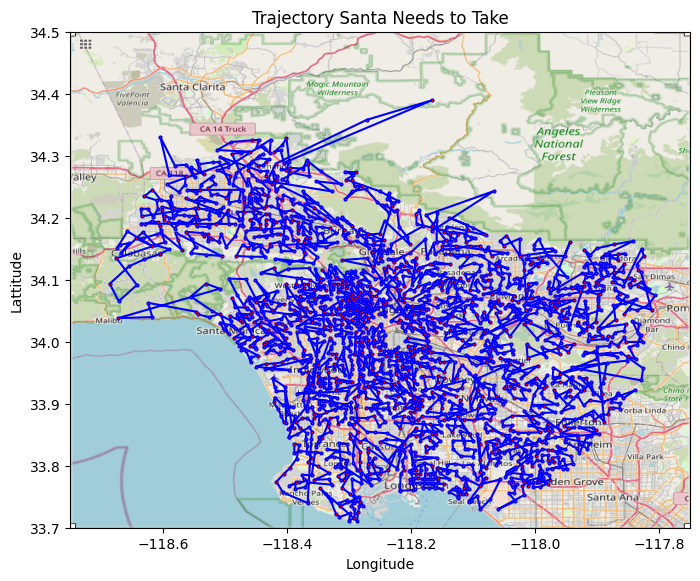

In [13]:
la_bounds = ((-118.75, -117.75, 33.7, 34.5))
la_map = plt.imread("la_map.png")
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(xs, ys, color="blue", marker="o", markersize=2, markerfacecolor="red")
ax.set_title("Trajectory Santa Needs to Take")
plt.xlabel("Longitude")
plt.ylabel("Lattitude")
ax.set_xlim(la_bounds[0], la_bounds[1])
ax.set_ylim(la_bounds[2], la_bounds[3])
ax.imshow(la_map, zorder=0, extent=la_bounds, aspect="equal")
plt.show()

### 4. Analysing Traffic Flow
***
Next December, there is going to be a large group of visitors travelling between a location near Malibu to a location near Long Beach. We would like to analyse the maximum traffic that can flow between the two locations.

### 5. Estimate the Roads
***
We want to estimate the map of roads without using actual road datasets. Educate yourself about Delaunay triangulation algorithm and then apply it to the nodes coordinates.

#### QUESTION 14: Plot the road mesh that you obtain and explain the result. Create a graph $G_∆$ whose nodes are different locations and its edges are produced by triangulation.

> Ans: The road mesh of LA area using Delaunay triangulation algorithm is plotted in the below cell. From the plot, we observed that the distribution is denser in the city area and sparser in the countryside. Also, since the edges are produced by algorithm, there are some roads crossing over oceans and mountains, which are not realistic.

> The graph $G_∆$ is generated in the below cell.

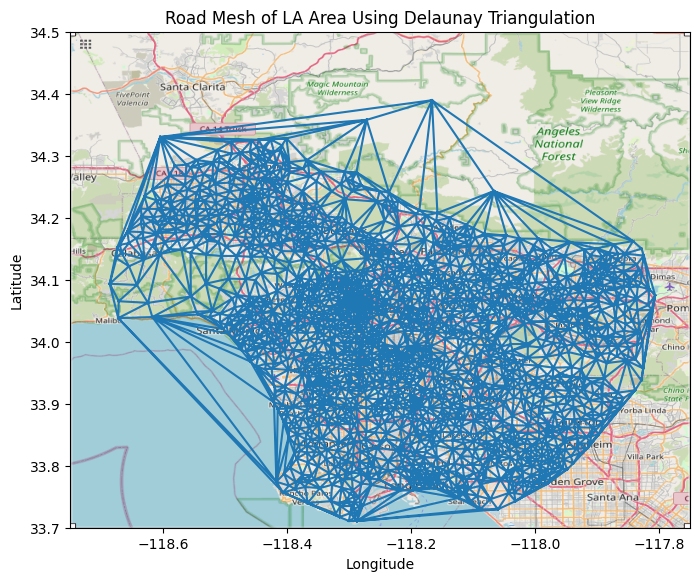

In [14]:
gcc_node_ids = {int(gcc_nx.nodes[i]["name"]) for i in range(len(gcc_nx.nodes))}
longitudes = []
latitudes = []
g_delta_node_id_map = {}
i = 0

for idx in range(1, len(loc_data)+1):
    if idx in gcc_node_ids:
        longitudes.append(loc_data[str(idx)]["mean_coords"][0])
        latitudes.append(loc_data[str(idx)]["mean_coords"][1])
        g_delta_node_id_map[i] = gcc_node_id_map[idx]
        i += 1
delaunay = Delaunay(tuple(zip(latitudes, longitudes)))

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(longitudes, latitudes, delaunay.simplices)
ax.set_title("Road Mesh of LA Area Using Delaunay Triangulation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim(la_bounds[0], la_bounds[1])
ax.set_ylim(la_bounds[2], la_bounds[3])
ax.imshow(la_map, zorder=0, extent=la_bounds, aspect="equal")
plt.show()

In [15]:
g_delta = ig.Graph()
g_delta.add_vertices(len(delaunay.points))
edges_existed = set()

for i in tqdm(range(len(delaunay.simplices))):
    a = tuple(sorted((delaunay.simplices[i][0], delaunay.simplices[i][1])))
    b = tuple(sorted((delaunay.simplices[i][0], delaunay.simplices[i][2])))
    c = tuple(sorted((delaunay.simplices[i][1], delaunay.simplices[i][2])))
    
    for e in (a, b, c):
        if e not in edges_existed:
            edges_existed.add(e)
            g_delta.add_edges([e])

len(g_delta.vs), len(g_delta.es)

  0%|          | 0/5275 [00:00<?, ?it/s]

(2649, 7923)

### 6. Calculate Road Traffic Flows
***
#### QUESTION 15: Using simple math, calculate the traffic flow for each road in terms of cars/hour. Report your derivation.
Hint: Consider the following assumptions:
+ Each degree of latitude and longitude ≈ 69 miles
+ Car length ≈ 5 m = 0.003 mile
+ Cars maintain a safety distance of 2 seconds to the next car
+ Each road has 2 lanes in each direction

Assuming no traffic jam, consider the calculated traffic flow as the max capacity of each road.

> Ans: The derivation of traffic flow is as below,

> (1) $\text{Velocity of car}=\frac{69}{\text{Mean travel time}/3600}\times\sqrt{(\text{Latitude}_1-\text{Latitude}_2)^2+(\text{Longitude}_1-\text{Longitude}_2)^2}$

> (2) $\text{Total distance}=\text{Velocity of car}\times\frac{\text{Mean travel time}}{3600}$

> (3) $\text{Gap}=0.003+\text{Velocity of car}\times\frac{2}{3600}$

> (4) $\text{Total number of cars on the road}=\frac{2\times\text{Total distance}}{\text{Gap}}$

> (5) $\text{Traffic flow (cars/hour)}=\frac{3600}{\text{Mean travel time}}\times\text{Total number of cars on the road}$

> By simplication, we have, $\text{Traffic flow (cars/hour)}=\frac{3600\times\text{Velocity of car}}{5.4+\text{Velocity of car}}$.

In [25]:
def compute_single_edge_traffic_flow(s, t):
    x1, x2 = longitudes[s], longitudes[t]
    y1, y2 = latitudes[s], latitudes[t]
    travel_time = all_shortest_paths[g_delta_node_id_map[s]][g_delta_node_id_map[t]]
    v_car = (69 * ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5) / travel_time * 3600
    return (3600 * v_car) / (5.4 + v_car)

In [35]:
g_delta_nx = g_delta.to_networkx()
attrs = {}

for e in tqdm(g_delta.es()):
    s, t = e.source, e.target
    traffic_flow = compute_single_edge_traffic_flow(s, t)
    attrs[(s, t)] = {"capacity": traffic_flow}
    
nx.set_edge_attributes(g_delta_nx, attrs)

  0%|          | 0/7923 [00:00<?, ?it/s]

### 7. Calculate Max Flow
***
Consider the following locations in terms of latitude and longitude:
+ Source coordinates (in Malibu): $[34.04, -118.56]$
+ Destination coordinates (in Long Beach): $[33.77, -118.18]$

#### QUESTION 16: Calculate the maximum number of cars that can commute per hour from Malibu to Long Beach. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match what you see on your road map?

> Ans: The maximum number of cars that can commute per hour from Malibu to Long Beach is **11074.145** and the number of edge-disjoint paths between two spots is **4**. When we checked the road map near Malibu and the road map near Long Beach, we observed that the number of nodes out from Malibu is 4 and the number of nodes pointing into Long Beach is 6. The minimum of these two numbers would be the maximum number of edge-disjoint paths, which is 4. The result shows that the roads are dense enough to find edge-disjoint paths for all four edges starting from Malibu.

In [39]:
# search nearest points
malibu_coords = [-118.56, 34.04]
long_beach_coords = [-118.18, 33.77]

min_malibu = np.inf
min_long_beach = np.inf
malibu_node = None
long_beach_node = None
nearest_malibu_node_coords = None
nearest_long_beach_coords = None
i = 0

for idx in range(1, len(loc_data)+1):
    if idx in gcc_node_ids:
        x, y = loc_data[str(idx)]["mean_coords"]
        malibu_distance = np.sqrt(
            (malibu_coords[0] - x) ** 2 + (malibu_coords[1] - y) ** 2
        )
        long_beach_distance = np.sqrt(
            (long_beach_coords[0] - x) ** 2 + (long_beach_coords[1] - y) ** 2
        )

        if malibu_distance < min_malibu:
            min_malibu = malibu_distance
            malibu_node = i
            nearest_malibu_node_coords = [x, y]
        if long_beach_distance < min_long_beach:
            min_long_beach = long_beach_distance
            long_beach_node = i
            nearest_long_beach_coords = [x, y]
        i += 1

max_car_per_hour = nx.maximum_flow(g_delta_nx, malibu_node, long_beach_node)
print("Maximum number of cars:", round(max_car_per_hour[0], 3))


def get_edge_disjoint_paths(G, s, t):
    G_nx = G.to_networkx()
    return list(nx.edge_disjoint_paths(G_nx, s, t))


edge_disjoint_paths = get_edge_disjoint_paths(g_delta, malibu_node, long_beach_node)
print("Number of edge-disjoint paths:", len(edge_disjoint_paths))

Maximum number of cars: 11074.145
Number of edge-disjoint paths: 4


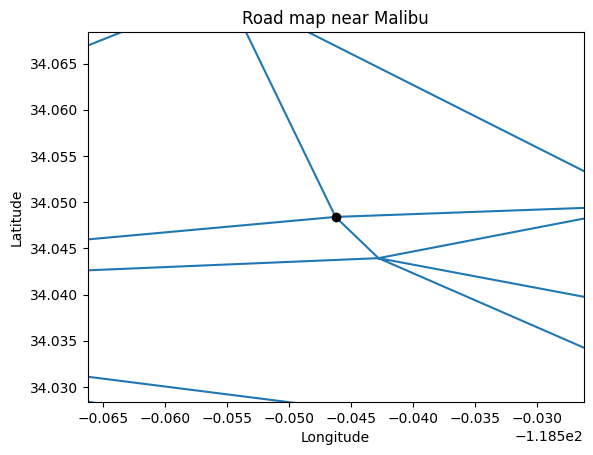

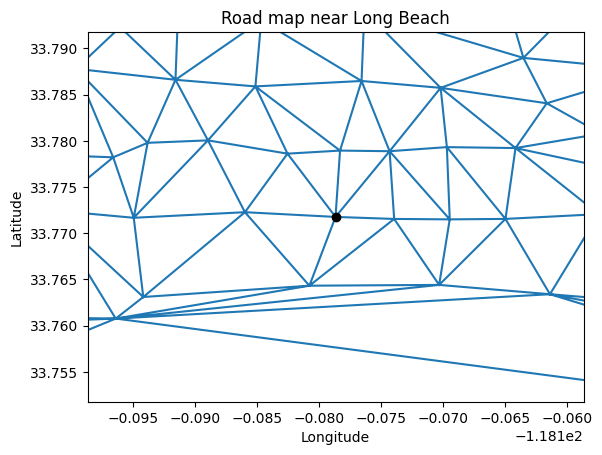

In [19]:
width = 0.02
x, y = nearest_malibu_node_coords
plt.triplot(longitudes, latitudes, delaunay.simplices)
plt.xlim(x-width, x+width)
plt.ylim(y-width, y+width)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Road map near Malibu")
plt.plot(x, y, "o", color="black")
plt.show()

x, y = nearest_long_beach_coords
plt.triplot(longitudes, latitudes, delaunay.simplices)
plt.xlim(x-width, x+width)
plt.ylim(y-width, y+width)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Road map near Long Beach")
plt.plot(x, y, "o", color="black")
plt.show()

### 8. Prune Your Graph
***
In $G_∆$, there are a number of unreal roads that could be removed. For instance, you might notice some unreal links along the concavities of the beach, as well as in the hills of Topanga. Apply a threshold on the travel time of the roads in $G_∆$ to remove the fake edges. Call the resulting graph $\tilde{G}_∆$.

#### QUESTION 17: Plot $\tilde{G}_∆$ on actual coordinates. Do you think the thresholding method worked?

> Ans: The resulting graph $\tilde{G}_∆$ is plotted in the below cell. From the plot, we can see that most of the unrealistic roads crossing over the oceans and mountains were removed, which indicates this thresholding method worked.

59 edges pruned.


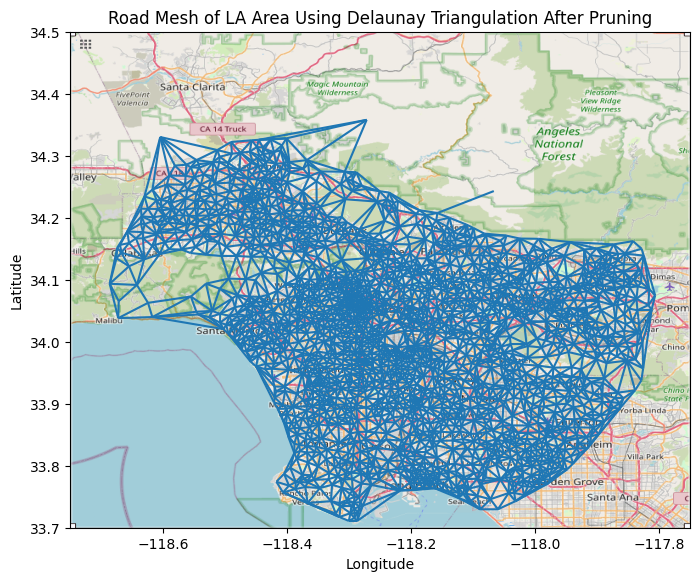

In [20]:
tilde_g_delta = ig.Graph()
tilde_g_delta.add_vertices(len(delaunay.points))
threshold = 800
points = np.array([[x, y] for x, y in zip(longitudes, latitudes)])
edges = []
n_pruned = 0

for e in g_delta.es():
    s, t = e.source, e.target
    if all_shortest_paths[g_delta_node_id_map[s]][g_delta_node_id_map[t]] < threshold:
        tilde_g_delta.add_edges([(s, t)])
        edges.append([s, t])
    else:
        n_pruned += 1
print(f"{n_pruned} edges pruned.")

edges = np.array(edges)
lc = LineCollection(points[edges])

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_title("Road Mesh of LA Area Using Delaunay Triangulation After Pruning")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim(la_bounds[0], la_bounds[1])
ax.set_ylim(la_bounds[2], la_bounds[3])
ax.imshow(la_map, zorder=0, extent=la_bounds, aspect="equal")
plt.gca().add_collection(lc)
plt.show()

#### QUESTION 18: Now, repeat question 16 for $\tilde{G}_∆$ and report the results. Do you see any changes? Why?

> Ans: The maximum number of cars that can commute per hour from Malibu to Long Beach is **11074.145** and the number of edge-disjoint paths between two spots is **4**, which both remain the same as question 16. Even though the maximum number of cars and the number of edge-disjoint paths are not changed, we can still observe that the mean length of edge-disjoint paths increased from 16.75 to 32.2 after pruning. That is because many roads were removed.

In [41]:
tilde_g_delta_nx = tilde_g_delta.to_networkx()
attrs = {}

for e in tqdm(tilde_g_delta.es()):
    s, t = e.source, e.target
    traffic_flow = compute_single_edge_traffic_flow(s, t)
    attrs[(s, t)] = {"capacity": traffic_flow}
    
nx.set_edge_attributes(tilde_g_delta_nx, attrs)

  0%|          | 0/7864 [00:00<?, ?it/s]

In [43]:
max_car_per_hour = nx.maximum_flow(tilde_g_delta_nx, malibu_node, long_beach_node)
print("Maximum number of cars:", round(max_car_per_hour[0], 3))

edge_disjoint_paths_pruned = get_edge_disjoint_paths(
    tilde_g_delta, malibu_node, long_beach_node
)
print("Number of edge-disjoint paths:", len(edge_disjoint_paths_pruned))

mean_len = np.mean([len(path) for path in edge_disjoint_paths])
mean_len_pruned = np.mean([len(path) for path in edge_disjoint_paths_pruned])
print("Original mean length of edge-disjoint paths:", round(mean_len, 3))
print("Mean length of edge-disjoint paths after pruning:", round(mean_len_pruned, 3))

Maximum number of cars: 11074.145
Number of edge-disjoint paths: 4
Original mean length of edge-disjoint paths: 16.75
Mean length of edge-disjoint paths after pruning: 32.5


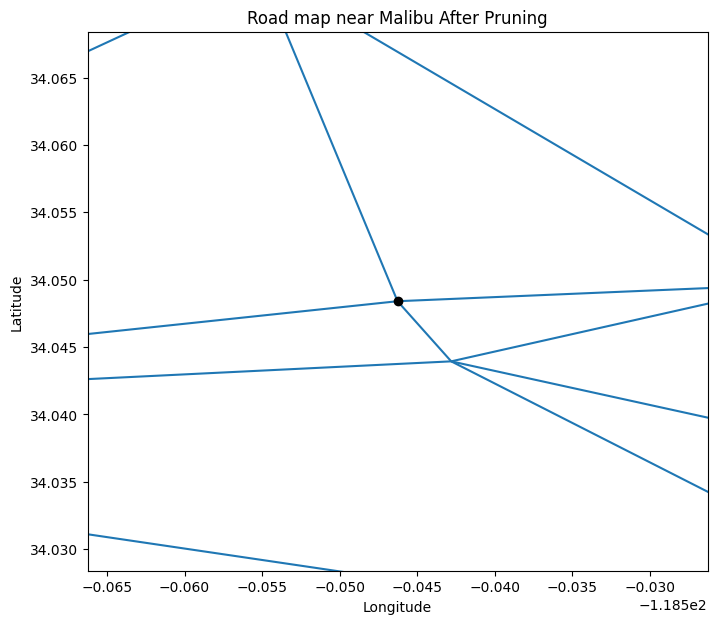

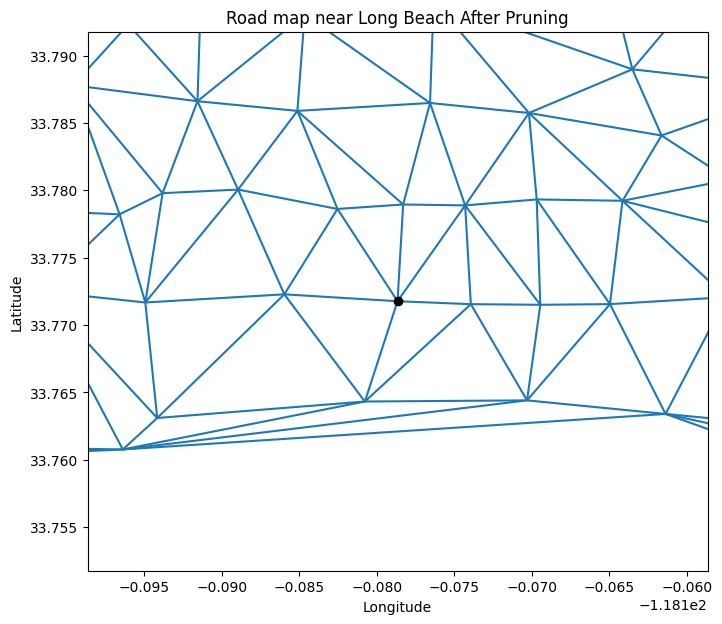

In [22]:
width = 0.02
x, y = nearest_malibu_node_coords
lc = LineCollection(points[edges])
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_title("Road map near Malibu After Pruning")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim(la_bounds[0], la_bounds[1])
ax.set_ylim(la_bounds[2], la_bounds[3])
plt.gca().add_collection(lc)
plt.axis([x-width, x+width, y-width, y+width])
plt.plot(x, y, "o", color="black")
plt.show()

x, y = nearest_long_beach_coords
lc = LineCollection(points[edges])
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_title("Road map near Long Beach After Pruning")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_xlim(la_bounds[0], la_bounds[1])
ax.set_ylim(la_bounds[2], la_bounds[3])
plt.gca().add_collection(lc)
plt.axis([x-width, x+width, y-width, y+width])
plt.plot(x, y, "o", color="black")
plt.show()

### 9. Construct New Roads
***
Let us assume that the output of question 17 (graph $\tilde{G}_∆$) is the actual road network of LA. The government of LA wants to construct 20 new roads (each road is an edge). They ask you to help them decide where to construct the roads. In other words, you have to create 20 new edges in the graph.

#### QUESTION 19: Strategy 1 (geo distance, static): Reduce the maximum extra travelling distance. The extra travelling distance between 2 locations is the difference of the shortest traveling distance and the straight line distance. i.e extra_distance(v,s) = distance_of_shortest_path(v,s) - euclidean_distance(v,s). Use the coordinates of v and s to get the euclidean distance between them. Calculate the extra distance between all pairs of points. The top 20 pairs with highest extra distance will be the new edges we suggest. Print the source and destination of these pairs and write them in your report. Create these new edges in the graph, and plot the resultant graph on actual coordinates. What is the time complexity of the strategy?

> Ans: For pairs with no paths, we set a large value to represent infinity distance since it is unreachable. The sources and destinations of the top 20 pairs with the highest extra distance are printed in the below cell. The graph with new edges is also shown in the below cell.

> The steps for finding the top 20 pairs with the highest extra distance are: (1) calculate weights (euclidean distance) for all paths. (2) find the shortest paths for all pairs. (3) calculate extra distances for all pairs. (4) sort extra distances for all pairs. (5) return top 20 pairs with highest extra distance. Therefore, the time complexity are $O(|E|)$ for (1), $O(|V|(|V|+|E|)\log|V|)$ for (2), $O(|V|^2)$ for (3), and $O(|V|^2\log|V|)$ for (4). In this case, we observe that $|E|\approx3|V|\Rightarrow O(|E|)=O(|V|)$. Therefore, after simplification, the time complexity for strategy 1 is $O(|V|^2\log|V|)$.

In [204]:
def get_sorted_extra_distances(G):
    
    # add weights to network G
    G_nx = G.to_networkx()
    attrs = {}

    for e in tqdm(G.es()):
        s, t = e.source, e.target
        weight = compute_single_edge_distance(s, t)
        attrs[(s, t)] = {"weight": weight}

    nx.set_edge_attributes(G_nx, attrs)
    
    # calculate shortest distances for all pairs
    all_shortest_distances = all_pairs_shortest_path_length(G_nx)
    
    # calculate extra distances for all pairs
    n_node = len(G_nx)
    extra_distances = []
    inf = 1e6  # if there is no path, set to a large value

    for i in tqdm(range(n_node-1)):
        for j in range(i+1, n_node):
            extra_distance = (
                all_shortest_distances[i].get(j, inf)
                - compute_single_edge_distance(i, j)
            )
            extra_distances.append((extra_distance, i, j))
    
    return sorted(extra_distances, reverse=True)


def compute_single_edge_distance(s, t):
    x1, x2 = longitudes[s], longitudes[t]
    y1, y2 = latitudes[s], latitudes[t] 
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def print_coordinates(arr):
    for i, (_, s, t) in enumerate(arr):
        x1, x2 = longitudes[s], longitudes[t]
        y1, y2 = latitudes[s], latitudes[t]  
        print(f"\nedge {i+1}: ({x1}, {y1}) - ({x2}, {y2})")


def plot_graph_with_new_roads(new_edges):
    new_edges_array = np.array([[s, t] for _, s, t in new_edges])
    lc_old = LineCollection(points[edges])
    lc_new = LineCollection(points[new_edges_array], colors="red")
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.set_title(
        "Road Mesh of LA Area Using Delaunay Triangulation After Creating New roads"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    ax.set_xlim(la_bounds[0], la_bounds[1])
    ax.set_ylim(la_bounds[2], la_bounds[3])
    ax.imshow(la_map, zorder=0, extent=la_bounds, aspect="equal")
    plt.gca().add_collection(lc_old)
    plt.gca().add_collection(lc_new)
    plt.show()

  0%|          | 0/7864 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

Top 20 pairs with highest extra distance: (distance, v, s)
[(999999.8899602315, 2418, 2421), (999999.8357921552, 2135, 2418), (999999.831631739, 1684, 2418), (999999.8307363386, 340, 2418), (999999.8286904375, 509, 2418), (999999.8247041225, 686, 2418), (999999.8246166888, 2136, 2418), (999999.8232761223, 2244, 2418), (999999.8227698414, 2418, 2420), (999999.8215760017, 688, 2418), (999999.8215101181, 507, 2418), (999999.8214202614, 689, 2418), (999999.8180394385, 695, 2418), (999999.8178907557, 2242, 2418), (999999.8175523097, 685, 2418), (999999.8170489479, 504, 2418), (999999.814949783, 2137, 2418), (999999.814878125, 508, 2418), (999999.814474637, 1801, 2418), (999999.8139777906, 341, 2418)]

edge 1: (-118.16620295644888, 34.38948489307656) - (-118.27158981797648, 34.35782482248528)

edge 2: (-118.2356042706767, 34.240663947368446) - (-118.16620295644888, 34.38948489307656)

edge 3: (-118.28809007500001, 34.2733324) - (-118.16620295644888, 34.38948489307656)

edge 4: (-118.25063870

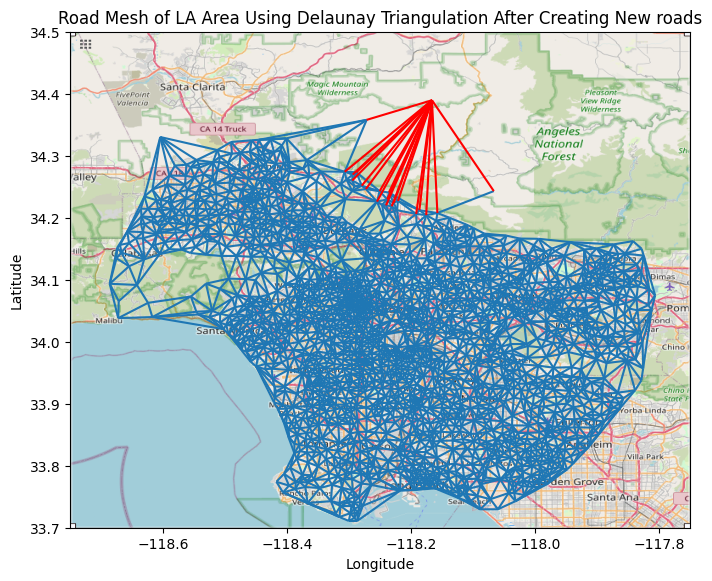

In [214]:
k = 20
extra_distances = get_sorted_extra_distances(tilde_g_delta)
extra_distances_topk = extra_distances[:k]
print("Top 20 pairs with highest extra distance: (distance, v, s)")
print(extra_distances_topk)
print_coordinates(extra_distances_topk)
plot_graph_with_new_roads(extra_distances_topk)

In [215]:
cur_graph = tilde_g_delta.copy()
for _, x, y in tqdm(extra_distances_topk):
    cur_graph.add_edges([(x, y)])
extra_distances_with_new_edges = get_sorted_extra_distances(cur_graph)
print("The highest extra distance after adding new edges: (distance, v, s)")
print(extra_distances_with_new_edges[0])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7884 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.183110321817979, 2140, 2420)


#### QUESTION 20: Strategy 2 (geo distance, static, with frequency): In strategy1, we are using the geographical distance between points to decide which new road to create. However, in the real world, some pairs are more in demand than other pairs. Assume that you know the frequency of travel between every pair. Use the frequency as the weight to multiply the difference. i.e weighted_extra_distance(v,s) = extra_distance(v,s) * frequency(v,s) where frequency(v,s) is a random integer between $[1,1000]$. Use the coordinates of v and s to get the euclidean distance between them. Calculate the weighted extra distance between all pairs of points. The top 20 pairs with highest weighted extra distance will be the new edges we suggest. Print the source and destination of these pairs and write them in your report. Create these new edges in the graph, and plot the resultant graph on actual coordinates. What is the time complexity of the strategy?

> Ans: The sources and destinations of the top 20 pairs with the highest weighted extra distance are printed in the below cell. The graph with new edges is also shown in the below cell.

> The steps for finding the top 20 pairs with the highest weighted extra distance are: (1) calculate weights (euclidean distance) for all paths. (2) find the shortest paths for all pairs. (3) calculate weighted extra distances for all pairs. (4) sort weighted extra distances for all pairs. (5) return top 20 pairs with highest weighted extra distance. The time complexity for strategy 2 is the same as strategy 1, which is $O(|V|^2\log|V|)$.

  0%|          | 0/3507276 [00:00<?, ?it/s]

Top 20 pairs with highest weighted extra distance: (distance, v, s)
[(999999598.3036423, 1409, 2418), (999999596.3569827, 746, 2418), (999999574.6325488, 2153, 2418), (998999780.0179836, 1805, 2418), (998999666.4809935, 1130, 2418), (998999463.7199732, 524, 2418), (997999623.0029517, 71, 2418), (996999645.6392359, 1727, 2418), (996999514.0727477, 957, 2418), (996999496.7827204, 328, 2418), (995999623.6890547, 1733, 2418), (995999620.6918511, 2267, 2418), (995999615.9942467, 1739, 2418), (995999600.0470456, 2198, 2418), (995999592.0130638, 552, 2418), (995999493.2980093, 215, 2418), (995999457.2309802, 156, 2418), (994999599.7929591, 2270, 2418), (994999577.0687598, 1443, 2418), (994999525.8501548, 1760, 2418)]

edge 1: (-118.28854333333331, 34.006871777777775) - (-118.16620295644888, 34.38948489307656)

edge 2: (-118.55507863580257, 34.281302679012335) - (-118.16620295644888, 34.38948489307656)

edge 3: (-117.85588418181818, 34.098555818181815) - (-118.16620295644888, 34.38948489307656

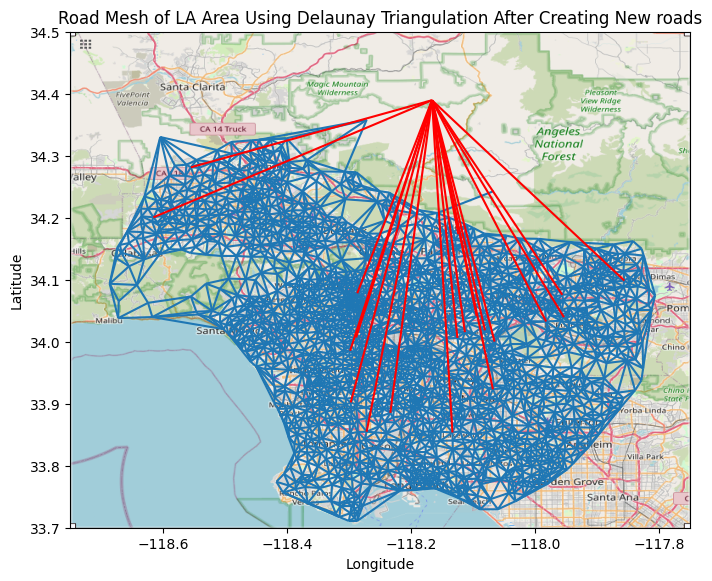

In [216]:
weighted_extra_distances = [
    (extra_distance*random.randint(1, 1000), i, j)
    for extra_distance, i, j in tqdm(extra_distances)
]
weighted_extra_distances_topk = sorted(weighted_extra_distances, reverse=True)[:k]
print("Top 20 pairs with highest weighted extra distance: (distance, v, s)")
print(weighted_extra_distances_topk)
print_coordinates(weighted_extra_distances_topk)
plot_graph_with_new_roads(weighted_extra_distances_topk)

In [217]:
cur_graph = tilde_g_delta.copy()
for _, x, y in tqdm(weighted_extra_distances_topk):
    cur_graph.add_edges([(x, y)])
weighted_extra_distances_with_new_edges = get_sorted_extra_distances(cur_graph)

print("The highest extra distance after adding new edges: (distance, v, s)")
print(weighted_extra_distances_with_new_edges[0])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7884 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.41432485804064134, 2418, 2421)


#### QUESTION 21: Strategy 3 (geo distance, dynamic): In the above strategy, we are creating all roads at the same time. This time, we will create the roads one by one. Repeat 20 times: i) Compute extra distance between all the pairs in the graph. ii) Create a road between the pair with highest extra distance and update the graph. iii) Print the source and destination of this new edge. Report the source and destination of the 20 new edges. plot the final graph on actual coordinates. What is the time complexity of the strategy?

> Ans: The sources and destinations of the 20 new edges are printed in the below cell. The final graph is also shown in the below cell.

> The steps for strategy 3 are: (1) calculate weights (euclidean distance) for all paths. (2) find the shortest paths for all pairs. (3) calculate extra distances for all pairs. (4) sort extra distances for all pairs. (5) add an edge with the highest extra distance to the graph. (6) repeat (1)~(5) for 20 times then get the final result. To sum up, strategy 3 is basically conducting strategy 1 for 20 times. Therefore, assume that K is the number of new roads, the time complexity for strategy 3 is $O(K|V|^2\log|V|)$.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7864 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7865 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7866 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7867 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7868 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7869 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7870 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7871 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7872 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7873 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7874 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7875 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7876 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7877 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7878 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7879 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7880 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7881 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7882 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7883 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

Top 20 pairs with highest extra distance (dynamic): (distance, v, s)
[(999999.8899602315, 2418, 2421), (0.29749669219110136, 2140, 2418), (0.2898288396346922, 2418, 2420), (0.183110321817979, 2140, 2420), (0.17756647528999658, 285, 2418), (0.1716543805599868, 285, 2420), (0.14425669584919498, 1956, 2418), (0.14212670521334925, 22, 2420), (0.1317401160196094, 509, 2418), (0.10041855229667535, 1783, 2416), (0.09881402191574115, 989, 1510), (0.0926930547033758, 1800, 2420), (0.0880548931972035, 2421, 2598), (0.08631380761131269, 511, 2421), (0.08099737228791043, 2210, 2421), (0.08083221170940535, 57, 2421), (0.08034495697161337, 32, 2421), (0.07991475015368743, 1957, 2421), (0.07783201112820429, 2247, 2421), (0.07355128068398348, 1783, 2417)]

edge 1: (-118.16620295644888, 34.38948489307656) - (-118.27158981797648, 34.35782482248528)

edge 2: (-117.84197423684212, 34.16224818421053) - (-118.16620295644888, 34.38948489307656)

edge 3: (-118.16620295644888, 34.38948489307656) - (-118.066476

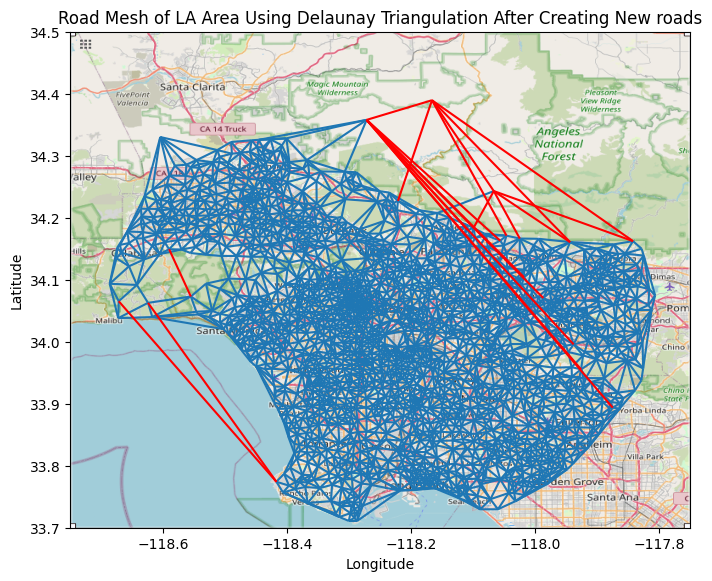

In [218]:
cur_graph = tilde_g_delta.copy()
extra_distances_topk_dynamic = []

for _ in tqdm(range(k)):
    max_extra_distance = get_sorted_extra_distances(cur_graph)[0]
    extra_distances_topk_dynamic.append(max_extra_distance)
    cur_graph.add_edges([(max_extra_distance[1], max_extra_distance[2])])

print("Top 20 pairs with highest extra distance (dynamic): (distance, v, s)")
print(extra_distances_topk_dynamic)
print_coordinates(extra_distances_topk_dynamic)
plot_graph_with_new_roads(extra_distances_topk_dynamic)

In [219]:
max_extra_distance = get_sorted_extra_distances(cur_graph)[0]

print("The highest extra distance after adding new edges: (distance, v, s)")
print(max_extra_distance)

  0%|          | 0/7884 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

The highest extra distance after adding new edges: (distance, v, s)
(0.07304768831314037, 2241, 2421)


#### QUESTION 22: Strategy 4 (Travel time, static): We want to optimize to reduce the maximum extra travelling time. The extra travelling distance between 2 locations is the difference of the shortest traveling time and the straight line travel time. i.e extra_time(v,s) = travel_time_of_shortest_path(v,s) - euclidean_distance(v,s) / travel_speed(v,s) and travel_speed(v,s) = distance_of_shortest_path(v,s) / travel_time_of_shortest_path(v,s). Use the coordinates of v and s to get the euclidean distance between them. Calculate the extra time between all pairs of points. The top 20 pairs with highest extra time will be the new edges we suggest. Print the source and destination of these pairs and write them in your report. Create these new edges in the graph, and plot the resultant graph on actual coordinates. What is the time complexity of the strategy? What is the time complexity of the strategy?

> Ans: For pairs with no paths, we set a large value to represent infinity travel time and an arbitary number 1 to represent unknown travel speed since it is unreachable. The sources and destinations of the top 20 pairs with the highest extra time are printed in the below cell. The resultant graph is also shown in the below cell.

> The steps for strategy 4 are: (1) calculate weights (euclidean distance) for all paths. (2) find the shortest paths for all pairs. (3) calculate extra times for all pairs. (4) sort extra times for all pairs. (5) return top 20 pairs with highest extra time. Therefore, the time complexity are $O(|E|)$ for (1), $O(|V|(|V|+|E|)\log|V|)$ for (2), $O(|V|^3)$ for (3), and $O(|V|^2\log|V|)$ for (4). Similarly, with $O(|E|)=O(|V|)$, the simplified time complexity will be $O(|V|^3)$.

In [194]:
def all_pairs_shortest_path_info(G):
    with Pool(24) as pool:
        results = pool.starmap(
            single_source_shortest_path_info, [(G, n) for n in G]
        )
    
    return dict(results)


def single_source_shortest_path_info(G, n):
    shortest_paths = nx.single_source_dijkstra_path(G, n)
    results = {}
    for k, shortest_path in shortest_paths.items():
        distance = 0
        travel_time = 0
        eps = 1e-6
        for i, j in zip(shortest_path[:-1], shortest_path[1:]):
            distance += compute_single_edge_distance(i, j)
            travel_time += all_shortest_paths[g_delta_node_id_map[i]][g_delta_node_id_map[j]]
        results[k] = {"travel_time": travel_time, "speed": distance / (travel_time + eps)}
    return (n, results)

In [195]:
def get_sorted_extra_times(G):
    
    # add weights to network G
    G_nx = G.to_networkx()
    attrs = {}

    for e in tqdm(G.es()):
        s, t = e.source, e.target
        weight = compute_single_edge_distance(s, t)
        attrs[(s, t)] = {"weight": weight}

    nx.set_edge_attributes(G_nx, attrs)
    
    # calculate travel time and speed of shortest path for all pairs
    all_pairs_info = all_pairs_shortest_path_info(G_nx)
    
    # calculate extra distances for all pairs
    n_node = len(G_nx)
    extra_times = []
    inf = 1e6  # if there is no path, set travel time to a large value

    for i in tqdm(range(n_node-1)):
        for j in range(i+1, n_node):
            info = all_pairs_info[i].get(j)
            if info is None:
                # if there is no path, the speed is undefined
                # so set to an arbitrary number
                extra_time = inf - compute_single_edge_distance(i, j) / 1
            else:
                extra_time = (
                    info["travel_time"]
                    - compute_single_edge_distance(i, j) / info["speed"]
                )
            extra_times.append((extra_time, i, j))
    
    return sorted(extra_times, reverse=True)

  0%|          | 0/7864 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

Top 20 pairs with highest extra time: (time, v, s)
[(999999.8899602315, 2418, 2421), (999999.8357921552, 2135, 2418), (999999.831631739, 1684, 2418), (999999.8307363386, 340, 2418), (999999.8286904375, 509, 2418), (999999.8247041225, 686, 2418), (999999.8246166888, 2136, 2418), (999999.8232761223, 2244, 2418), (999999.8227698414, 2418, 2420), (999999.8215760017, 688, 2418), (999999.8215101181, 507, 2418), (999999.8214202614, 689, 2418), (999999.8180394385, 695, 2418), (999999.8178907557, 2242, 2418), (999999.8175523097, 685, 2418), (999999.8170489479, 504, 2418), (999999.814949783, 2137, 2418), (999999.814878125, 508, 2418), (999999.814474637, 1801, 2418), (999999.8139777906, 341, 2418)]
edge 1: (-118.16620295644888, 34.38948489307656) - (-118.27158981797648, 34.35782482248528)
edge 2: (-118.2356042706767, 34.240663947368446) - (-118.16620295644888, 34.38948489307656)
edge 3: (-118.28809007500001, 34.2733324) - (-118.16620295644888, 34.38948489307656)
edge 4: (-118.2506387010309, 34.24

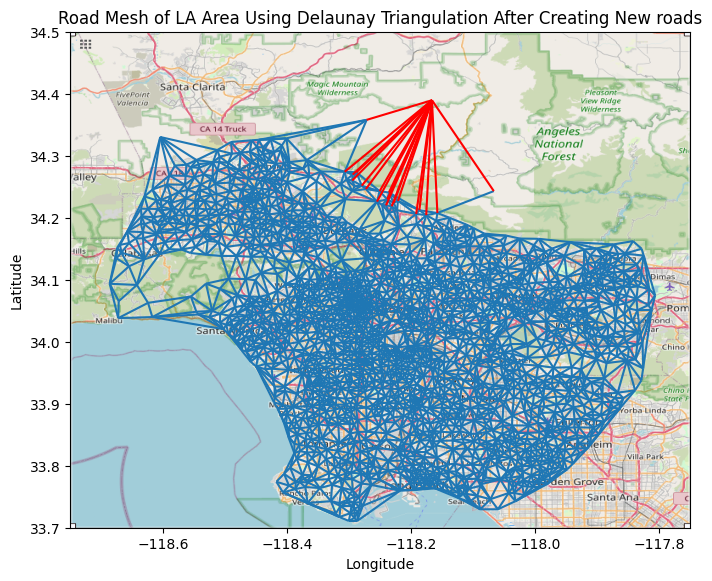

In [196]:
extra_times_topk = get_sorted_extra_times(tilde_g_delta)[:k]
print("Top 20 pairs with highest extra time: (time, v, s)")
print(extra_times_topk)
print_coordinates(extra_times_topk)
plot_graph_with_new_roads(extra_times_topk)

#### QUESTION 23: Strategy 5 (Travel time, dynamic): Similar to strategy 3, this time we will create roads one by one while optimizing the travel time. Repeat 20 times: i) Compute extra time between all the pairs in the graph. ii) Create a road between the pair with highest extra time and update the graph. iii) Print the source and destination of this new edge. Report the source and destination of the 20 new edges. plot the final graph on actual coordinates. What is the time complexity of the strategy?

> Ans: The sources and destinations of the 20 new edges are printed in the below cell. The final graph is also shown in the below cell.

> The steps for strategy 5 are: (1) calculate weights (euclidean distance) for all paths. (2) find the shortest paths for all pairs. (3) calculate extra times for all pairs. (4) sort extra times for all pairs. (5) add an edge with the highest extra time to the graph. (6) repeat (1)~(5) for 20 times then get the final result. To sum up, strategy 5 is basically conducting strategy 4 for 20 (K) times. Therefore, the time complexity for strategy 5 is $O(K|V|^3)$.

  0%|          | 0/20 [00:01<?, ?it/s]

  0%|          | 0/7864 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7865 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7866 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7867 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7868 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7869 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7870 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7871 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7872 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7873 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7874 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7875 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7876 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7877 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7878 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7879 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7880 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7881 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7882 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

  0%|          | 0/7883 [00:00<?, ?it/s]

  0%|          | 0/2648 [00:00<?, ?it/s]

Top 20 pairs with highest extra time (dynamic): (time, v, s)
[(999999.8899602315, 2418, 2421), (3060.208963219211, 257, 2418), (2849.804708177778, 2140, 2418), (2619.1260304191205, 2418, 2420), (1875.6892073848894, 258, 2420), (1745.2450141196387, 2420, 2581), (1703.6934420301786, 382, 2420), (1751.540076902231, 53, 2420), (1633.1026977317779, 1723, 2420), (1566.0292050457138, 171, 2418), (1522.667706972663, 1494, 2418), (1378.996708710457, 1393, 2418), (1354.2106616394876, 1065, 2418), (1272.2120272534448, 1957, 2418), (1269.104402306703, 1957, 2420), (1242.5707878315516, 509, 2418), (1224.9296046527404, 951, 1510), (1244.6456764330112, 987, 1510), (1211.868387916924, 1860, 2416), (1125.0380472467205, 2421, 2598)]
edge 1: (-118.16620295644888, 34.38948489307656) - (-118.27158981797648, 34.35782482248528)
edge 2: (-117.82657713380283, 33.99942785211269) - (-118.16620295644888, 34.38948489307656)
edge 3: (-117.84197423684212, 34.16224818421053) - (-118.16620295644888, 34.38948489307656)

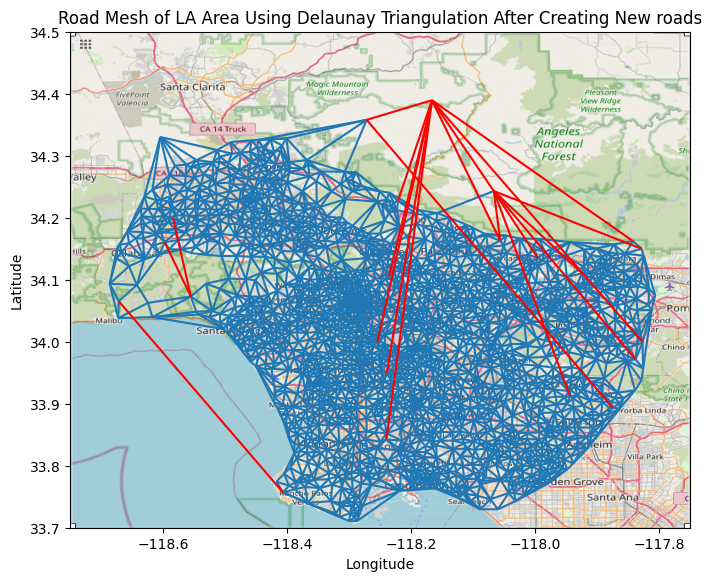

In [197]:
cur_graph = tilde_g_delta.copy()
extra_times_topk_dynamic = []

for _ in tqdm(range(k)):
    max_extra_time = get_sorted_extra_times(cur_graph)[0]
    extra_times_topk_dynamic.append(max_extra_time)
    cur_graph.add_edges([(max_extra_time[1], max_extra_time[2])])

print("Top 20 pairs with highest extra time (dynamic): (time, v, s)")
print(extra_times_topk_dynamic)
print_coordinates(extra_times_topk_dynamic)
plot_graph_with_new_roads(extra_times_topk_dynamic)

#### QUESTION 24: Strategy comparison. Compare the following strategies:
+ a) 1 vs 2 - compare and analyze the results. which is better? why?
+ b) 1 vs 3 - compare and analyze the results. which is better? why?
+ c) 1 vs 4 - compare and analyze the results. which is better? why?
+ d) statics vs dynamic - Considering we want to improve the overall road network by constructing new roads, is either of them the optimal strategy?
    + i) if yes, which one and why?
    + ii) if not, what would be a better strategy to construct roads and is it optimal? What is the time complexity?
    + (assume that you want to reduce travelling distances and you know before hand that we have to construct 20 new roads).
+ e) Open ended question : Come up with new strategy. You are free to make any assumptions. You don’t have to necessarily optimize traveling time or distance, you can come up with any constraints. justify your strategy.


> Ans:

> (a) The difference between strategy 1 and strategy 2 is that strategy 2 multiplied with a random number between [1, 1000] to extra distance as weighted extra distance. Since the scales of extra distance and weighted extra distance are different, we can not directly compare them. As a result, we choose to compare the highest extra distance (i.e. unweighted extra distance) after adding new edges. From the results, we observed that after they both added new edges, the highest extra distance for strategy 1 is 0.1831 while for strategy 2 is 0.4143. Also, the time complexities for both strategies are the same. Therefore, strategy 1 is better than strategy 2. To inspect why strategy 2 performed worse, we think it might be due to the large range of random number strategy 2 added as weights. The weights are diverse so that they could easily change the distribution of extra distance and impact the choices of new edges.

> (b) For strategy 1, after creating the new edges from the top 20 pairs with the highest extra distance, the remaining highest extra distance is around 0.1831. However, for strategy 3, after iterating 20 times for calculating extra distances for all pairs and adding new edges from pair with the highest extra distance, the remaining highest extra distance is around 0.07305. Therefore, strategy 3 is better for distance concern than strategy 1. However, strategy 3 requires higher time complexity than strategy 1 since it needs to iterate strategy 1 for 20 times. So, which strategy is better depends on what you care more. If distance is more important for you, then strategy 3 is better, but strategy 1 is better if you care more about the time complexity.

> (c) The 20 new edges selected by strategy 1 are the same as those selected by strategy 4. That is because for pairs with no paths, we set the same large number to represent infinity distance and infinity travel time, and the travel speed to be an arbitary number 1 since it is unknown. In this case, the extra distances and extra times for pairs with no paths will be the same. Therefore, for the purpose of minimizing the highest extra distance or extra time, strategy 1 and strategy 4 are the same. However, for time complexity, strategy 4 is worse because it needs to calculate travel time for all pairs so its complexity will be $O(|V|^3)$. Combining the conclusions together, we argue that strategy 1 is better than strategy 4.

> (d) If Ignoring time complexity, dynamic strategy is clearly better than static strategy since its highest extra distance after creating new edges is smaller than using static strategy. However, dynamic strategy with greedy choice proposed in the question is still not optimal since counterexample exists. For instance, as the plot below, assume we have 5 nodes $A, B, C, D, E$, and 4 edges $\bar{AB}$ with $w=2$, $\bar{BC}$ with $w=2$, $\bar{CD}$ with $w=1$, and $\bar{DE}$ with $w=1$. We have top 3 pairs with the highest distance $(A, E)$, $(B, E)$, and $(A, D)$ which $Extra(A, E)=6-\sqrt{10}\approx{2.838}$, $Extra(B, E)=4-\sqrt{2}\approx{2.586}$, and $Extra(A, D)=5-\sqrt{17}\approx{0.877}$. If we apply dynamic strategy, a new road between $A$ and $E$ will be created and then the highest extra distance become $Extra(B, E)\approx{2.586}$ after adding this new edge. However, if we choose to create the new road between $B$ and $E$, the highest extra distance after adding this new edge will be $Extra(A, D)\approx{0.877}$, which is much smaller than $2.586$. Thus, dynamic strategy with greedy choice is not optimal.

<div>
<img src="24(d).png" width="150"/>
</div>

> To find the optimal solution, we should add one edge such that the new maximum extra distance is the minimal one for each iteration. One possible way is to try all non-existing edges and pick the best one. As for the time complexity, since we need to go through all non-existing edges, which is $O(|E|)=O(|V|)$ in this case, the time complexity will become $O(K|V|^3\log|V|)$.

> (e) For the new strategy, we hope to reduce the time complexity because we find that calculating all-pairs shortest paths is the major bottleneck. So, we propose an approximating algorithm by Baswana and Kavitha proposed in 2010. The steps of their algorithm are shown as below. In their paper, they also proved that the approximate distance will be close to the real distance even in the worse case. Since $O(|E|)=O(|V|)$ in our case, we can utilize a 3-approximation algotithm which will reduce the time complexity from $O(|V|^2\log|V|)$ to $O(|V|\sqrt{|V|})$.
>
> Ref: [FASTER ALGORITHMS FOR ALL-PAIRS APPROXIMATE SHORTEST PATHS IN UNDIRECTED GRAPHS](https://www.cse.iitk.ac.in/users/sbaswana/Papers-published/journal-focs06.pdf)

<div>
<img src="24(e).png" width="500"/>
</div>
